# Import Necessary Libraries

In [1]:
import pandas as pd
import gzip
import shutil
import seaborn as sns
import numpy as np
import tensorflow as tf
import sklearn
import time
import xgboost as xgb
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score, mean_squared_error, \
mean_absolute_error, explained_variance_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from keras import models, layers 
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, \
GlobalAveragePooling1D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from geopy.distance import geodesic

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Exploratory Data Analysis (EDA)

## Calendar Data - 2022

In [2]:
#Load raw calendar data from file
raw_calendar_data = pd.read_csv('../Data/AirBnB/Austin/2021/austin_calendar_2021.csv', compression='gzip')
raw_calendar_data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,5456,2022-03-13,f,$250.00,$250.00,2.0,90.0
1,5456,2022-03-14,f,$250.00,$250.00,2.0,90.0
2,5456,2022-03-15,f,$250.00,$250.00,2.0,90.0
3,5456,2022-03-16,f,$250.00,$250.00,2.0,90.0
4,5456,2022-03-17,t,$250.00,$250.00,2.0,90.0
...,...,...,...,...,...,...,...
4369412,580590011933192873,2023-03-07,f,"$10,000.00","$10,000.00",3.0,365.0
4369413,580590011933192873,2023-03-08,f,"$10,000.00","$10,000.00",3.0,365.0
4369414,580590011933192873,2023-03-09,f,"$10,000.00","$10,000.00",3.0,365.0
4369415,580590011933192873,2023-03-10,f,"$10,000.00","$10,000.00",3.0,365.0


In [3]:
#Check the info / types of data
raw_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369417 entries, 0 to 4369416
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 233.4+ MB


In [4]:
#Convert date column to date-times type
mod_calendar_data = raw_calendar_data
mod_calendar_data['date'] = pd.to_datetime(raw_calendar_data['date'])

#Confirm the info / types of data
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369417 entries, 0 to 4369416
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 233.4+ MB


In [5]:
print(f"Earliest date of data set {raw_calendar_data['date'].min()}")
print(f"Latest date of data set {raw_calendar_data['date'].max()}")

Earliest date of data set 2022-03-12 00:00:00
Latest date of data set 2023-03-30 00:00:00


In [6]:
#Check Values of 'Available column'
mod_calendar_data['available'].value_counts()

f    2706886
t    1662531
Name: available, dtype: int64

In [7]:
#Replace the false and true values with 0 and 1
mod_calendar_data['available'] = mod_calendar_data['available'].replace(['f', 't'],[0, 1])

#Confirm available are now integers
mod_calendar_data['available'].value_counts()

0    2706886
1    1662531
Name: available, dtype: int64

In [8]:
#Check if there are NaN values for a specific airbnb
nan_cols = mod_calendar_data[mod_calendar_data['price'].isna()]
nan_cols['listing_id'].value_counts()

43611005    168
Name: listing_id, dtype: int64

In [9]:
#Drop the specific airbnb
bnb_to_drop = mod_calendar_data[(mod_calendar_data['listing_id'] == 43611005)].index
mod_calendar_data = mod_calendar_data.drop(bnb_to_drop)
mod_calendar_data['price'].isna().sum()

0

In [10]:
#Remove the '$' and ',' from prices then convert the values to integers
test_price_df = mod_calendar_data['price'].str.split(".", expand=True)
test_price_df = test_price_df.rename(columns = {0 : 'daily_price'})
test_price_df = test_price_df.drop(labels = [1], axis = 1)
mod_calendar_data = test_price_df.join(mod_calendar_data, how = 'left')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace(',', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].astype({'daily_price':'int'})
mod_calendar_data = mod_calendar_data.drop(labels = ['adjusted_price', 'price'], axis = 1)

#Move the listing_id column to the begininning of the dataframe
id_to_move = mod_calendar_data.pop('listing_id')
mod_calendar_data.insert(0, 'listing_id', id_to_move)
mod_calendar_data

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_9870/3443857727.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')


,listing_id,daily_price,date,available,minimum_nights,maximum_nights
0,5456,250,2022-03-13,0,2.0,90.0
1,5456,250,2022-03-14,0,2.0,90.0
2,5456,250,2022-03-15,0,2.0,90.0
3,5456,250,2022-03-16,0,2.0,90.0
4,5456,250,2022-03-17,1,2.0,90.0
...,...,...,...,...,...,...
4369412,580590011933192873,10000,2023-03-07,0,3.0,365.0
4369413,580590011933192873,10000,2023-03-08,0,3.0,365.0
4369414,580590011933192873,10000,2023-03-09,0,3.0,365.0
4369415,580590011933192873,10000,2023-03-10,0,3.0,365.0


In [11]:
#For purposes of this project/the stakeholder, we will drop the adjusted avail, price, min nights, max nights
mod_calendar_data = mod_calendar_data.drop(['available', 'minimum_nights', 'maximum_nights'],
                                          axis = 1)

#Check all columns are integer types
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4369052 entries, 0 to 4369416
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   listing_id   int64         
 1   daily_price  int64         
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 262.3 MB


## Listings Data - 2022

In [12]:
#Import opent the airbnb listings data set
raw_listings_data = pd.read_csv('../Data/AirBnB/Austin/2021/austin_listings_2021.csv')
raw_listings_data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5456,https://www.airbnb.com/rooms/5456,20220312074014,2022-03-13,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,https://www.airbnb.com/users/show/8028,...,4.81,4.73,4.78,NaN,f,1,1,0,0,3.69
1,5769,https://www.airbnb.com/rooms/5769,20220312074014,2022-03-31,NW Austin Room,<b>The space</b><br />Looking for a comfortabl...,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,https://www.airbnb.com/users/show/8186,...,4.94,4.74,4.92,NaN,f,1,0,1,0,1.81
2,6413,https://www.airbnb.com/rooms/6413,20220312074014,2022-03-31,Gem of a Studio near Downtown,"Great studio apartment, perfect a single perso...",Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/miso/Hosting-...,13879,https://www.airbnb.com/users/show/13879,...,4.98,4.86,4.94,NaN,t,1,1,0,0,0.78
3,6448,https://www.airbnb.com/rooms/6448,20220312074014,2022-03-12,"Secluded Studio @ Zilker - King Bed, Bright & ...","Clean, private space with everything you need ...",The neighborhood is fun and funky (but quiet)!...,https://a0.muscache.com/pictures/4513152/4ffc1...,14156,https://www.airbnb.com/users/show/14156,...,4.97,4.97,4.89,NaN,t,1,1,0,0,2.09
4,8502,https://www.airbnb.com/rooms/8502,20220312074014,2022-03-13,Woodland Studio Lodging,<b>The space</b><br />Fully furnished suite wi...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,25298,https://www.airbnb.com/users/show/25298,...,4.86,4.64,4.57,NaN,f,1,1,0,0,0.33


In [13]:
#Check the listings data information
raw_listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11972 non-null  int64  
 1   listing_url                                   11972 non-null  object 
 2   scrape_id                                     11972 non-null  int64  
 3   last_scraped                                  11972 non-null  object 
 4   name                                          11972 non-null  object 
 5   description                                   11808 non-null  object 
 6   neighborhood_overview                         7059 non-null   object 
 7   picture_url                                   11971 non-null  object 
 8   host_id                                       11972 non-null  int64  
 9   host_url                                      11972 non-null 

In [14]:
#Remove irrelevant review columns
mod_listing_data = raw_listings_data.drop(labels = ['review_scores_accuracy', 
                                                    'review_scores_cleanliness', 
                                                    'review_scores_checkin', 
                                                    'review_scores_communication', 
                                                    'review_scores_location',
                                                    'calendar_updated', 
                                                    'license'], axis = 1)

In [15]:
#Remove irrelevant host columns
mod_listing_data = mod_listing_data.drop(labels = ['host_name', 
                                                   'host_since', 
                                                   'host_location', 
                                                   'host_about', 
                                                   'host_response_time', 
                                                   'host_acceptance_rate',
                                                   'host_thumbnail_url', 
                                                   'host_picture_url', 
                                                   'host_neighbourhood', 
                                                   'host_listings_count', 
                                                   'host_total_listings_count', 
                                                   'host_verifications', 
                                                   'host_has_profile_pic',
                                                   'first_review',
                                                   'last_review'], axis = 1)

In [16]:
#Remove other irrelevant columns
mod_listing_data = mod_listing_data.drop(labels = ['scrape_id',
                                                  'last_scraped',
                                                  'neighbourhood_cleansed',
                                                  'neighbourhood_group_cleansed',
                                                  'property_type',
                                                  'bathrooms',
                                                  'price',
                                                   'minimum_minimum_nights',
                                                   'maximum_minimum_nights',
                                                   'minimum_maximum_nights',
                                                   'maximum_maximum_nights',
                                                   'minimum_nights_avg_ntm',
                                                   'maximum_nights_avg_ntm',
                                                   'has_availability',
                                                   'availability_30',
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'calendar_last_scraped',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'calculated_host_listings_count',
                                                   'calculated_host_listings_count_entire_homes',
                                                   'calculated_host_listings_count_private_rooms',
                                                   'calculated_host_listings_count_shared_rooms',
                                                  'neighborhood_overview',
                                                  'reviews_per_month',
                                                  'review_scores_value',
                                                  'host_response_rate',
                                                  'description'], axis = 1)

In [17]:
#Verify all of the above columns were removed
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11972 non-null  int64  
 1   listing_url             11972 non-null  object 
 2   name                    11972 non-null  object 
 3   picture_url             11971 non-null  object 
 4   host_id                 11972 non-null  int64  
 5   host_url                11972 non-null  object 
 6   host_is_superhost       11969 non-null  object 
 7   host_identity_verified  11969 non-null  object 
 8   neighbourhood           7059 non-null   object 
 9   latitude                11972 non-null  float64
 10  longitude               11972 non-null  float64
 11  room_type               11972 non-null  object 
 12  accommodates            11972 non-null  int64  
 13  bathrooms_text          11956 non-null  object 
 14  bedrooms                11261 non-null

In [18]:
#Fill the missing neighborhood data with 'Austin, Texas, United States'
mod_listing_data['neighbourhood'] = mod_listing_data['neighbourhood'].fillna('Austin, Texas, United States')
mod_listing_data['neighbourhood'].isna().sum()

0

In [19]:
#Split the neighbourhood column so that we are only left with the neighborhood name, not state and country
test_neighbor_df = mod_listing_data['neighbourhood'].str.split(",", expand=True)
test_neighbor_df = test_neighbor_df.rename(columns = {0 : 'neighborhood'})
test_neighbor_df = test_neighbor_df.drop(labels = [1, 2, 3], axis = 1)
mod_listing_data = mod_listing_data.join(test_neighbor_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['neighbourhood'], axis = 1)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11972 entries, 0 to 11971
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      11972 non-null  int64  
 1   listing_url             11972 non-null  object 
 2   name                    11972 non-null  object 
 3   picture_url             11971 non-null  object 
 4   host_id                 11972 non-null  int64  
 5   host_url                11972 non-null  object 
 6   host_is_superhost       11969 non-null  object 
 7   host_identity_verified  11969 non-null  object 
 8   latitude                11972 non-null  float64
 9   longitude               11972 non-null  float64
 10  room_type               11972 non-null  object 
 11  accommodates            11972 non-null  int64  
 12  bathrooms_text          11956 non-null  object 
 13  bedrooms                11261 non-null  float64
 14  beds                    11822 non-null

In [20]:
#Fix the typos
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Austin '],['Austin'])

#Drop the below neighborhoods as there is not enough data for each
neigh_to_drop = mod_listing_data[(mod_listing_data['neighborhood'] != 'Austin')].index
mod_listing_data = mod_listing_data.drop(neigh_to_drop)

#Verify the neighborhoods that are left
mod_listing_data['neighborhood'].value_counts()

Austin    11861
Name: neighborhood, dtype: int64

In [21]:
#Remove rows with no bedrooms data
mod_listing_data = mod_listing_data.dropna(subset = ['bedrooms', 
                                                     'beds', 
                                                     'review_scores_rating', 
                                                     'bathrooms_text'], axis = 0)
#Verify there are no NaNs
mod_listing_data.isna().sum()

id                        0
listing_url               0
name                      0
picture_url               0
host_id                   0
host_url                  0
host_is_superhost         2
host_identity_verified    2
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
neighborhood              0
dtype: int64

In [22]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_is_superhost'] = mod_listing_data['host_is_superhost'].replace(['f', 't'],[0, 1])
mod_listing_data['host_is_superhost'].value_counts()

0.0    4941
1.0    3314
Name: host_is_superhost, dtype: int64

In [23]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_identity_verified'] = mod_listing_data['host_identity_verified'].replace(['f', 't'],[0, 1])
mod_listing_data['host_identity_verified'].value_counts()

1.0    6992
0.0    1263
Name: host_identity_verified, dtype: int64

In [24]:
#Replace the false and true values with 0 and 1
mod_listing_data['instant_bookable'] = mod_listing_data['instant_bookable'].replace(['f', 't'],[0, 1])
mod_listing_data['instant_bookable'].value_counts()

0    4878
1    3379
Name: instant_bookable, dtype: int64

In [25]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath               3419
2 baths              1839
2.5 baths             670
1 shared bath         535
1 private bath        466
1.5 baths             418
3 baths               365
3.5 baths             142
1.5 shared baths      120
4 baths                99
4.5 baths              52
5 baths                30
2 shared baths         21
5.5 baths              12
6.5 baths              11
2.5 shared baths       10
6 baths                 9
3 shared baths          9
0 baths                 7
0 shared baths          5
7.5 baths               4
Half-bath               4
7 baths                 2
8 baths                 2
4 shared baths          2
17 baths                1
10.5 baths              1
8.5 baths               1
Private half-bath       1
Name: bathrooms_text, dtype: int64

In [26]:
#Replace the bathrooms_text data that are only text values with the correct numeric value
mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 
                                                                                'Private half-bath'],
                                                                                 [0.5, 0.5, 0.5])

In [27]:
#Create a bathrooms text test dataframe which splits the values based on spacing
test_df = mod_listing_data['bathrooms_text'].str.split(" ", expand=True)
test_df = test_df.rename(columns = {0 : 'bathrooms'})
test_df = test_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['bathrooms_text'], axis = 1)
mod_listing_data['bathrooms'] = mod_listing_data['bathrooms'].fillna(0.5)
mod_listing_data['bathrooms'] = pd.to_numeric(mod_listing_data['bathrooms'])
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8257 entries, 0 to 11879
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      8257 non-null   int64  
 1   listing_url             8257 non-null   object 
 2   name                    8257 non-null   object 
 3   picture_url             8257 non-null   object 
 4   host_id                 8257 non-null   int64  
 5   host_url                8257 non-null   object 
 6   host_is_superhost       8255 non-null   float64
 7   host_identity_verified  8255 non-null   float64
 8   latitude                8257 non-null   float64
 9   longitude               8257 non-null   float64
 10  room_type               8257 non-null   object 
 11  accommodates            8257 non-null   int64  
 12  bedrooms                8257 non-null   float64
 13  beds                    8257 non-null   float64
 14  amenities               8257 non-null  

In [28]:
#Create a function which will return a true or false value if the chosen amenity is present in the aribnb's amenities
#column
def add_amenity_column(amenity_name):
    mod_listing_data[amenity_name] = mod_listing_data['amenities'].str.contains(amenity_name, regex=False)
    mod_listing_data[amenity_name] = mod_listing_data[amenity_name].replace([False, True],[0, 1])

In [29]:
#Create a list of the target amenities and apply the function
target_amenities = ['Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']
add_amenity_column(target_amenities[0])
add_amenity_column(target_amenities[1])
add_amenity_column(target_amenities[2])
add_amenity_column(target_amenities[3])
add_amenity_column(target_amenities[4])
add_amenity_column(target_amenities[5])
add_amenity_column(target_amenities[6])
mod_listing_data = mod_listing_data.drop(['amenities'], axis = 1)

In [30]:
#Rename the 'id' column to 'listing_id' so it is consistent with the calendar data
mod_listing_data['listing_id'] = mod_listing_data['id']

#Remove the id column
mod_listing_data = mod_listing_data.drop(['id'], axis = 1)

#Move the listing_id column to the start
column_to_move = mod_listing_data.pop('listing_id')
mod_listing_data.insert(0, 'listing_id', column_to_move)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8257 entries, 0 to 11879
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              8257 non-null   int64  
 1   listing_url             8257 non-null   object 
 2   name                    8257 non-null   object 
 3   picture_url             8257 non-null   object 
 4   host_id                 8257 non-null   int64  
 5   host_url                8257 non-null   object 
 6   host_is_superhost       8255 non-null   float64
 7   host_identity_verified  8255 non-null   float64
 8   latitude                8257 non-null   float64
 9   longitude               8257 non-null   float64
 10  room_type               8257 non-null   object 
 11  accommodates            8257 non-null   int64  
 12  bedrooms                8257 non-null   float64
 13  beds                    8257 non-null   float64
 14  minimum_nights          8257 non-null  

## Combine Calendar Data and Listings Data

In [31]:
#Combine the mod_listing_data and mod_calendar data
austin_data = pd.merge(mod_listing_data, mod_calendar_data, how = 'left', on = 'listing_id')
austin_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3013807 entries, 0 to 3013806
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   listing_id              int64         
 1   listing_url             object        
 2   name                    object        
 3   picture_url             object        
 4   host_id                 int64         
 5   host_url                object        
 6   host_is_superhost       float64       
 7   host_identity_verified  float64       
 8   latitude                float64       
 9   longitude               float64       
 10  room_type               object        
 11  accommodates            int64         
 12  bedrooms                float64       
 13  beds                    float64       
 14  minimum_nights          int64         
 15  maximum_nights          int64         
 16  number_of_reviews       int64         
 17  review_scores_rating    float64       
 18  in

### Drop Outliers

In [32]:
austin_data.describe()

,listing_id,host_id,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,minimum_nights,...,instant_bookable,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price
count,3.013807e+06,3.013807e+06,3.013077e+06,3.013077e+06,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06,...,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06,3.013807e+06
mean,1.770984e+16,1.051290e+08,4.014537e-01,8.470019e-01,3.028101e+01,-9.775063e+01,4.901658e+00,2.001332e+00,2.701949e+00,7.101367e+00,...,4.092283e-01,1.616083e+00,9.169190e-01,9.572484e-01,8.974204e-01,9.190990e-01,7.335596e-01,6.598040e-01,8.155506e-01,3.822306e+02
std,9.730658e+16,1.216571e+08,4.901925e-01,3.599857e-01,6.295431e-02,6.219327e-02,3.156991e+00,1.256929e+00,2.419930e+00,2.931946e+01,...,4.916915e-01,8.773304e-01,2.760046e-01,2.022965e-01,3.034090e-01,2.726831e-01,4.420973e-01,4.737750e-01,3.878503e-01,1.027682e+03
min,5.456000e+03,2.300000e+01,0.000000e+00,0.000000e+00,3.011357e+01,-9.805370e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.752460e+07,1.115273e+07,0.000000e+00,1.000000e+00,3.024235e+01,-9.776828e+01,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+02
50%,3.440050e+07,5.067121e+07,0.000000e+00,1.000000e+00,3.026815e+01,-9.774104e+01,4.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.750000e+02
75%,4.950475e+07,1.572792e+08,1.000000e+00,1.000000e+00,3.030755e+01,-9.771810e+01,6.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,...,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.120000e+02
max,5.775962e+17,4.464130e+08,1.000000e+00,1.000000e+00,3.051034e+01,-9.757298e+01,1.600000e+01,2.300000e+01,6.100000e+01,1.100000e+03,...,1.000000e+00,1.700000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.200000e+04


In [33]:
#Drop the very few NaNs
austin_data = austin_data.dropna()

#Verify the NaNs were dropped
austin_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3013077 entries, 0 to 3013806
Data columns (total 30 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   listing_id              int64         
 1   listing_url             object        
 2   name                    object        
 3   picture_url             object        
 4   host_id                 int64         
 5   host_url                object        
 6   host_is_superhost       float64       
 7   host_identity_verified  float64       
 8   latitude                float64       
 9   longitude               float64       
 10  room_type               object        
 11  accommodates            int64         
 12  bedrooms                float64       
 13  beds                    float64       
 14  minimum_nights          int64         
 15  maximum_nights          int64         
 16  number_of_reviews       int64         
 17  review_scores_rating    float64       
 18  in

In [34]:
#Include bathrooms which are only between 1 and 5
austin_data = austin_data[austin_data['bathrooms'] <= 6]
austin_data = austin_data[austin_data['bathrooms'] >= 1]

#Include bedrooms which are less than or equal to 6 and beds which are less than or equal to 11
austin_data = austin_data[austin_data['bedrooms'] <= 6]
austin_data = austin_data[austin_data['beds'] <= 11]

#Exclude hotel rooms and shared rooms
austin_data = austin_data[austin_data['room_type'] != 'Hotel room']
austin_data = austin_data[austin_data['room_type'] != 'Shared room']

#Only include daily prices which are less than $1000
austin_data = austin_data[austin_data['daily_price'] <= 1000]

In [35]:
#Reset the index and drop the index column
austin_data = austin_data.reset_index()
austin_data = austin_data.drop(['index'], axis = 1)

In [36]:
#Test the geodesic function
origin = (30.172705, 31.526725)  # (latitude, longitude) don't confuse
dist = (30.288281, 31.732326)

print(geodesic(origin, dist).meters)  # 23576.805481751613
print(geodesic(origin, dist).kilometers)  # 23.576805481751613
print(geodesic(origin, dist).miles) # 14.64994773134371

23576.805481751613
23.576805481751613
14.64994773134371


In [37]:
#Zip the latitude and longitude columns to a new column called 'coords'
austin_data['coords'] = list(zip(austin_data['latitude'],austin_data['longitude']))

#Create variables for popular tourist attractions
falls_park = (30.183392637834487, -97.72267422932967) 
downtown = (30.273273348730932, -97.74476987419511)
capitol = (30.27482266440739, -97.74030758049228)

#Calculate the distance in miles from the airbnb coords to the tourist attractions
for idx, coords in enumerate(austin_data['coords']):
        austin_data.loc[idx,'distance_to_falls_park'] = geodesic(coords, falls_park).miles
        austin_data.loc[idx,'distance_to_downtown'] = geodesic(coords, downtown).miles
        austin_data.loc[idx,'distance_to_capitol'] = geodesic(coords, capitol).miles
    

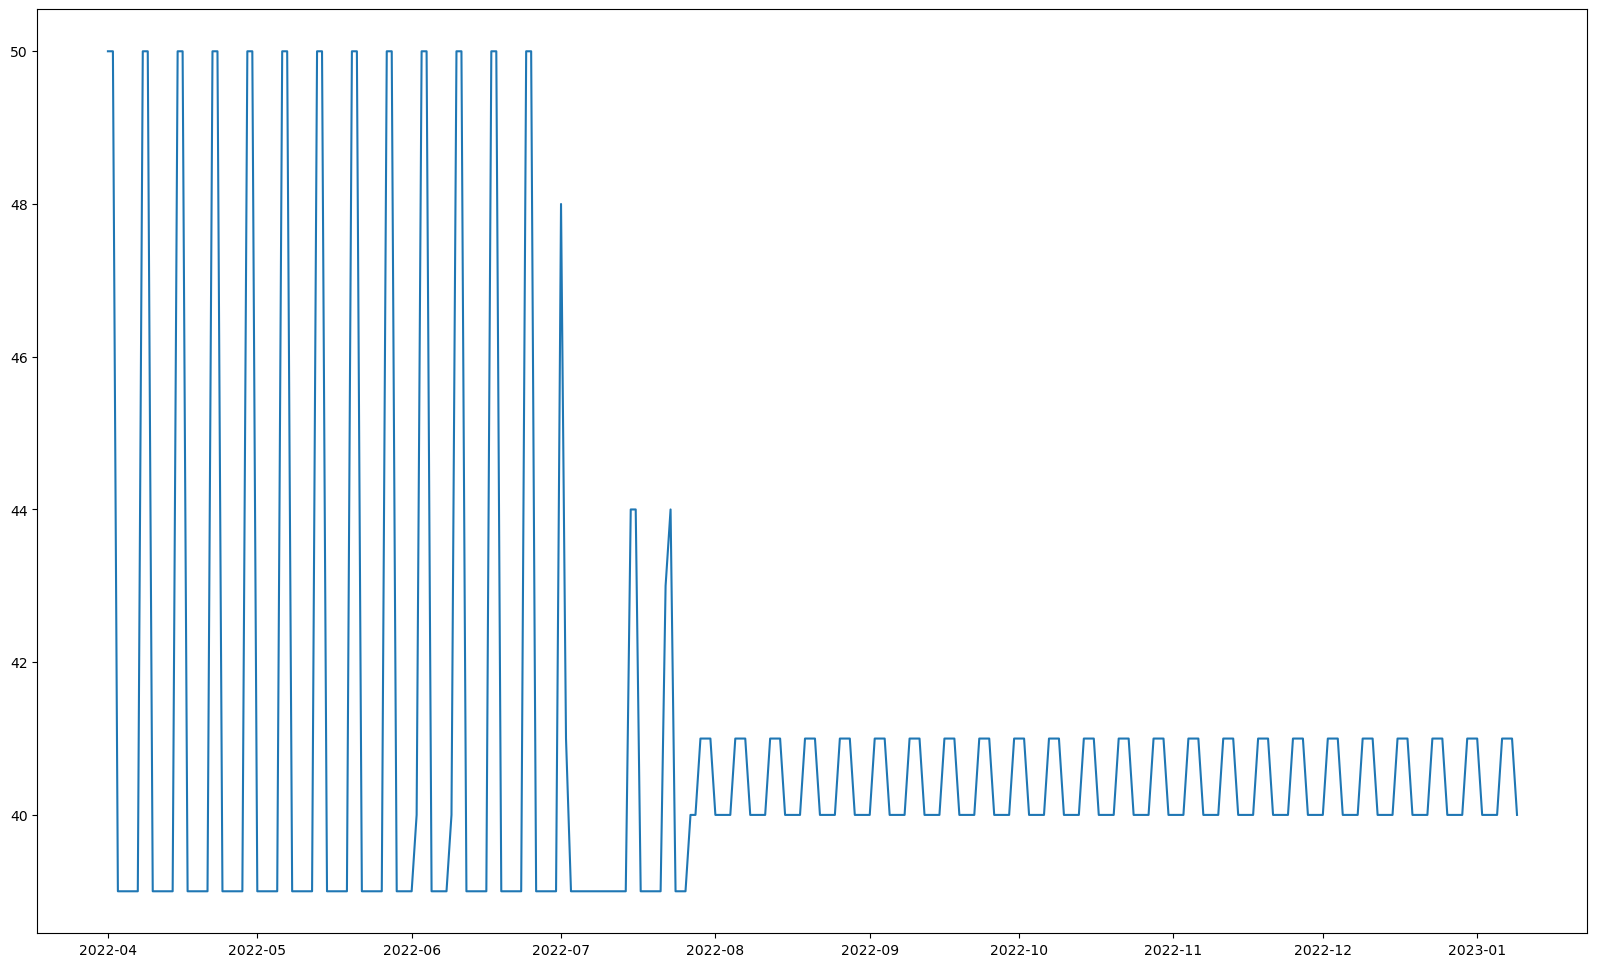

In [38]:
#Graph one airbnb's 365 daily price to view any seasonality
graphing_one_bnb = austin_data[366:650]
y_graphing_one_bnb = graphing_one_bnb['daily_price']
x_graphing_one_bnb = graphing_one_bnb['date']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.plot(x_graphing_one_bnb, y_graphing_one_bnb)
plt.show()

In [39]:
#Create a modeling data dataframe which exculdes other irrelevant columns
austin_modeling_data = austin_data.drop(['listing_url', 'name', 'picture_url', 'host_id',
                                              'host_url', 'host_identity_verified', 'latitude', 'longitude',
                                              'minimum_nights', 'maximum_nights', 'number_of_reviews',
                                              'instant_bookable', 'review_scores_rating'], axis = 1)
austin_modeling_data.head()

,listing_id,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,...,Kitchen,Washer,Dryer,Heating,daily_price,date,coords,distance_to_falls_park,distance_to_downtown,distance_to_capitol
0,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-13,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
1,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-14,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
2,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-15,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
3,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-16,"(30.26057, -97.73441)",5.362349,1.072111,1.043179
4,5456,1.0,Entire home/apt,3,1.0,2.0,Austin,1.0,1,1,...,1,0,0,1,250,2022-03-17,"(30.26057, -97.73441)",5.362349,1.072111,1.043179


In [40]:
#Create new columns for the day of the week, month, and week
austin_modeling_data['day_of_week'] = austin_modeling_data['date'].dt.dayofweek
austin_modeling_data['month'] = austin_modeling_data['date'].dt.month
austin_modeling_data['week'] = austin_modeling_data['date'].dt.week

#Drop the date column
austin_modeling_data = austin_modeling_data.drop(['date'], axis = 1)

#Verify the new columns
austin_modeling_data.info()

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_9870/1540626260.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  austin_modeling_data['week'] = austin_modeling_data['date'].dt.week


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2815576 entries, 0 to 2815575
Data columns (total 23 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   listing_id              int64  
 1   host_is_superhost       float64
 2   room_type               object 
 3   accommodates            int64  
 4   bedrooms                float64
 5   beds                    float64
 6   neighborhood            object 
 7   bathrooms               float64
 8   Air conditioning        int64  
 9   Wifi                    int64  
 10  TV                      int64  
 11  Kitchen                 int64  
 12  Washer                  int64  
 13  Dryer                   int64  
 14  Heating                 int64  
 15  daily_price             int64  
 16  coords                  object 
 17  distance_to_falls_park  float64
 18  distance_to_downtown    float64
 19  distance_to_capitol     float64
 20  day_of_week             int64  
 21  month                   int64  

## Baseline Model - Neural Network

In [41]:
#One hot encode the categorical columns
baseline_model_sklearn = austin_modeling_data
baseline_model_cat = baseline_model_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop="first", sparse=False)
ohe.fit(baseline_model_cat)

baseline_model_cat_ohe = pd.DataFrame(data = ohe.transform(baseline_model_cat),
                              columns = ohe.get_feature_names_out())
baseline_model_cat_ohe

,room_type_Private room,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815571,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2815572,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2815573,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2815574,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
#Merge the one hot encoded dataframe and the numeric columns
baseline_model_numeric = austin_modeling_data[['listing_id', 'daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'week']]

baseline_model_comb_ohe = baseline_model_numeric.join(baseline_model_cat_ohe, how = 'left')
baseline_model_comb_ohe


,listing_id,daily_price,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
0,5456,250,1.0,3,1.0,2.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5456,250,1.0,3,1.0,2.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5456,250,1.0,3,1.0,2.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5456,250,1.0,3,1.0,2.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5456,250,1.0,3,1.0,2.0,1.0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2815571,577596199055496685,159,0.0,5,1.0,3.0,1.0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2815572,577596199055496685,159,0.0,5,1.0,3.0,1.0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2815573,577596199055496685,159,0.0,5,1.0,3.0,1.0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2815574,577596199055496685,199,0.0,5,1.0,3.0,1.0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
#Create a baseline X and y variable
baseline_model_X = baseline_model_comb_ohe.drop(['daily_price', 'listing_id'], axis = 1)
baseline_model_y = baseline_model_comb_ohe['daily_price']

#Split the data set to train and test
baseline_model_X_train, baseline_model_X_test, baseline_model_y_train, baseline_model_y_test = train_test_split(
                                                                                                baseline_model_X, 
                                                                                                baseline_model_y, 
                                                                                                test_size = 0.18)

#Further split the data to a validation set
baseline_model_X_train, baseline_model_X_val, baseline_model_y_train, baseline_model_y_val = train_test_split(
                                                                                                baseline_model_X_train, 
                                                                                                baseline_model_y_train,
                                                                                                test_size = 0.12)

#Instantiate a new scaler and scale/transform the data
scaler = StandardScaler()
baseline_model_X_train_scaled = scaler.fit_transform(baseline_model_X_train)
baseline_model_X_test_scaled = scaler.transform(baseline_model_X_test)
baseline_model_X_val_scaled = scaler.transform(baseline_model_X_val)

In [44]:
#Instantiate a Regularizer
reg = l2(3e-3)

baseline_model_nn = models.Sequential()
baseline_model_nn.add(layers.Flatten())
baseline_model_nn.add(layers.Dense(16, activation = 'relu', input_shape=(34, 1), kernel_regularizer = reg))
baseline_model_nn.add(layers.Dropout(0.5))
baseline_model_nn.add(layers.Dense(1))


#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.05, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
baseline_model_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
baseline_model_nn_histoire = baseline_model_nn.fit(baseline_model_X_train_scaled,
                                                   baseline_model_y_train.values,
                                                   callbacks = [es],
                                                   epochs = 50,
                                                   batch_size = 1000,
                                                   validation_data = (baseline_model_X_val_scaled, 
                                                                      baseline_model_y_val.values))

Metal device set to: Apple M1 Pro


2023-01-05 09:53:05.005901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-05 09:53:05.006035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2023-01-05 09:53:05.584402: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 09:53:05.749043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2032/2032 [==============================] - ETA: 0s - loss: 222.9987 - mse: 85359.5469 - mae: 222.8648

2023-01-05 09:53:17.688962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2032/2032 [==============================] - 13s 6ms/step - loss: 222.9987 - mse: 85359.5469 - mae: 222.8648 - val_loss: 219.2543 - val_mse: 83656.9531 - val_mae: 219.0264
Epoch 2/50
2032/2032 [==============================] - 12s 6ms/step - loss: 213.5662 - mse: 81223.9141 - mae: 213.1742 - val_loss: 207.4826 - val_mse: 78487.6953 - val_mae: 206.8971
Epoch 3/50
2032/2032 [==============================] - 13s 6ms/step - loss: 199.9819 - mse: 75251.6641 - mae: 199.1604 - val_loss: 191.9712 - val_mse: 71613.2422 - val_mae: 190.8989
Epoch 4/50
2032/2032 [==============================] - 13s 6ms/step - loss: 184.3106 - mse: 68075.5078 - mae: 182.9664 - val_loss: 174.5519 - val_mse: 63570.3789 - val_mae: 172.9296
Epoch 5/50
2032/2032 [==============================] - 13s 6ms/step - loss: 168.0520 - mse: 60094.3984 - mae: 166.1443 - val_loss: 156.2422 - val_mse: 54820.0508 - val_mae: 154.0476
Epoch 6/50
2032/2032 [==============================] - 13s 6ms/step - loss: 152.7335 - mse: 522

2032/2032 [==============================] - 12s 6ms/step - loss: 105.8526 - mse: 26924.1816 - mae: 105.2690 - val_loss: 91.6379 - val_mse: 22305.8926 - val_mae: 91.0728
Epoch 47/50
2032/2032 [==============================] - 12s 6ms/step - loss: 105.6411 - mse: 26839.8926 - mae: 105.0936 - val_loss: 91.5846 - val_mse: 22291.6875 - val_mae: 91.0543
Epoch 48/50
2032/2032 [==============================] - 12s 6ms/step - loss: 105.4940 - mse: 26838.5293 - mae: 104.9808 - val_loss: 91.5605 - val_mse: 22295.1484 - val_mae: 91.0635
Epoch 49/50
2032/2032 [==============================] - 12s 6ms/step - loss: 105.2564 - mse: 26746.3066 - mae: 104.7754 - val_loss: 91.5442 - val_mse: 22318.3828 - val_mae: 91.0790
Epoch 50/50
2032/2032 [==============================] - 13s 6ms/step - loss: 105.0054 - mse: 26686.6992 - mae: 104.5548 - val_loss: 91.4753 - val_mse: 22276.5859 - val_mae: 91.0386


In [45]:
#Print the train and test results of the model
baseline_model_nn_results_train = baseline_model_nn.evaluate(baseline_model_X_train_scaled, 
                                                             baseline_model_y_train.values)
baseline_model_nn_results_test = baseline_model_nn.evaluate(baseline_model_X_test_scaled, 
                                                            baseline_model_y_test.values)

print(f'Baseline Model Neural Network Train Results: {baseline_model_nn_results_train}')
print(f'Baseline Model Neural Network Test Results: {baseline_model_nn_results_test}')

15838/15838 [==============================] - 66s 4ms/step - loss: 91.3482 - mse: 22331.4180 - mae: 90.9117
Baseline Model Neural Network Train Results: [91.27970123291016, 22262.958984375, 90.84386444091797]
Baseline Model Neural Network Test Results: [91.34815216064453, 22331.41796875, 90.91167449951172]


In [46]:
#Print the model's summary
baseline_model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 82)                0         
                                                                 
 dense (Dense)               (None, 16)                1328      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [47]:
#Create the train and test predictions
baseline_model_nn_train_preds = baseline_model_nn.predict(baseline_model_X_train_scaled)
baseline_model_nn_test_preds = baseline_model_nn.predict(baseline_model_X_test_scaled)

2023-01-05 10:09:05.193911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


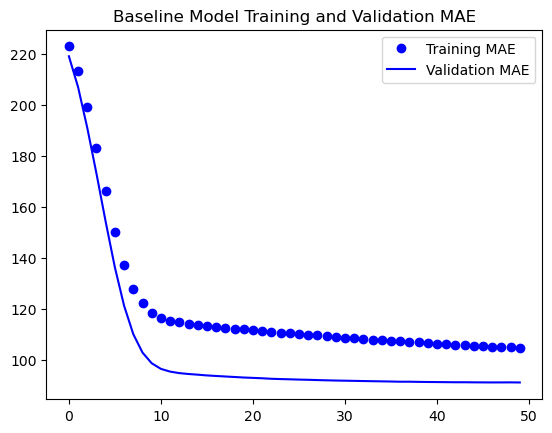

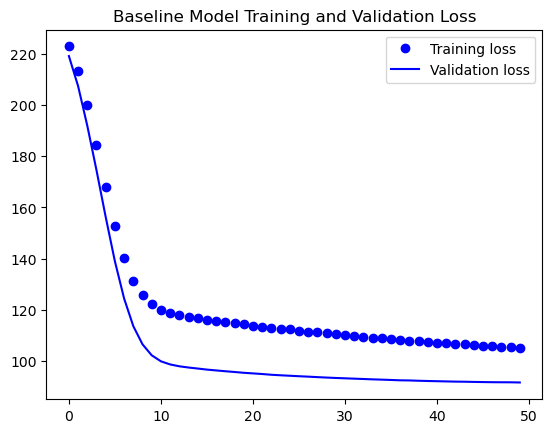

In [48]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
baseline_model_mae = baseline_model_nn_histoire.history['mae']
baseline_model_val_mae = baseline_model_nn_histoire.history['val_mae']
baseline_model_loss = baseline_model_nn_histoire.history['loss']
baseline_model_val_loss = baseline_model_nn_histoire.history['val_loss']
baseline_model_epochs = range(len(baseline_model_mae))

plt.plot(baseline_model_epochs, baseline_model_mae, 'bo', label = 'Training MAE')
plt.plot(baseline_model_epochs, baseline_model_val_mae, 'b', label = 'Validation MAE')
plt.title('Baseline Model Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(baseline_model_epochs, baseline_model_loss, 'bo', label = 'Training loss')
plt.plot(baseline_model_epochs, baseline_model_val_loss, 'b', label = 'Validation loss')
plt.title('Baseline Model Training and Validation Loss')
plt.legend()
plt.show();

In [49]:
print(f'Baseline Model train MAE w/ preds {mean_absolute_error(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model test MAE w/ preds {mean_absolute_error(baseline_model_y_test.values, baseline_model_nn_test_preds)}')

print(f'Baseline Model explained variance train score {explained_variance_score(baseline_model_y_train.values, baseline_model_nn_train_preds)}')
print(f'Baseline Model explained variance test score {explained_variance_score(baseline_model_y_test.values, baseline_model_nn_test_preds)}')

Baseline Model train MAE w/ preds 90.84422748279395
Baseline Model test MAE w/ preds 90.91171854750651
Baseline Model explained variance train score 0.43316585821697773
Baseline Model explained variance test score 0.43284202877782185


## Model 2 - Neural Network

In [50]:
#One hot encode the categorical columns
model2_sklearn = austin_modeling_data
model2_cat = model2_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month', 'week']]

ohe = OneHotEncoder(drop = 'first', sparse=False)
ohe.fit(model2_cat)

model2_cat_ohe = pd.DataFrame(data = ohe.transform(model2_cat),
                              columns = ohe.get_feature_names_out())

#Merge the one hot encoded dataframe and the numeric columns
model2_numeric = austin_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating', 'distance_to_falls_park', 'distance_to_downtown',
                                       'distance_to_capitol']]

model2_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')

In [51]:
#Begin modeling - set X and y variables
model2_X = model2_comb_ohe.drop(['daily_price'], axis = 1)
model2_y = model2_comb_ohe['daily_price']

model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_X, 
                                                                                model2_y, 
                                                                                test_size = 0.18)

model2_X_train, model2_X_val, model2_y_train, model2_y_val = train_test_split(model2_X_train, 
                                                                              model2_y_train,
                                                                              test_size = 0.12)

#Instantiate a new scaler
scaler = StandardScaler()

#Scale all columns
model2_X_train_scaled = scaler.fit_transform(model2_X_train)
model2_X_test_scaled = scaler.transform(model2_X_test)
model2_X_val_scaled = scaler.transform(model2_X_val)

In [52]:
#Instantiate a Regularizer
reg = l2(3e-3)

#Begin a new Sequential Model
model2_nn = models.Sequential()
#Consider going bigger to smaller filters between conv1d layers
model2_nn.add(layers.Conv1D(filters = 50, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.Dropout(0.5))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Conv1D(filters = 25, kernel_size = 3, activation = 'relu', padding = 'causal', 
                            input_shape = (model2_X_train_scaled.shape[1], 1)))
model2_nn.add(layers.MaxPooling1D(pool_size = 2))
model2_nn.add(layers.BatchNormalization())
model2_nn.add(layers.Dropout(0.4))
model2_nn.add(layers.Flatten())
model2_nn.add(layers.Dense(16, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(8, activation='relu', input_shape=(34, 1), kernel_regularizer = reg))
model2_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0001)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of 0.05, and a patience of 10
es = EarlyStopping(monitor = 'mae', mode = 'min', min_delta = 0.001, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model2_nn.compile(optimizer = opt,
                  loss = 'mae',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
model2_nn_histoire = model2_nn.fit(model2_X_train_scaled,
                                   model2_y_train.values,
                                   callbacks = [es],
                                   epochs = 120,
                                   batch_size = 1000,
                                   validation_data = (model2_X_val_scaled, model2_y_val.values))

Epoch 1/120


2023-01-05 10:12:54.930461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2032/2032 [==============================] - ETA: 0s - loss: 127.9610 - mse: 40722.7461 - mae: 127.7388

2023-01-05 10:13:33.221439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2032/2032 [==============================] - 41s 20ms/step - loss: 127.9610 - mse: 40722.7461 - mae: 127.7388 - val_loss: 89.8345 - val_mse: 21494.0410 - val_mae: 89.5341
Epoch 2/120
2032/2032 [==============================] - 41s 20ms/step - loss: 91.0972 - mse: 21224.8398 - mae: 90.7807 - val_loss: 86.2367 - val_mse: 19350.7383 - val_mae: 85.9117
Epoch 3/120
2032/2032 [==============================] - 41s 20ms/step - loss: 89.0371 - mse: 20402.3984 - mae: 88.7067 - val_loss: 85.0783 - val_mse: 18954.1680 - val_mae: 84.7436
Epoch 4/120
2032/2032 [==============================] - 41s 20ms/step - loss: 87.9571 - mse: 19943.7656 - mae: 87.6183 - val_loss: 84.4002 - val_mse: 18810.9121 - val_mae: 84.0571
Epoch 5/120
2032/2032 [==============================] - 39s 19ms/step - loss: 87.2681 - mse: 19628.8535 - mae: 86.9187 - val_loss: 83.8899 - val_mse: 18494.5137 - val_mae: 83.5339
Epoch 6/120
2032/2032 [==============================] - 38s 19ms/step - loss: 86.6761 - mse: 19397.8594 

2032/2032 [==============================] - 38s 19ms/step - loss: 81.9101 - mse: 17713.0527 - mae: 81.5889 - val_loss: 78.2946 - val_mse: 16386.8730 - val_mae: 77.9733
Epoch 92/120
2032/2032 [==============================] - 38s 19ms/step - loss: 81.9306 - mse: 17726.0234 - mae: 81.6097 - val_loss: 78.2547 - val_mse: 16585.0176 - val_mae: 77.9342
Epoch 93/120
2032/2032 [==============================] - 39s 19ms/step - loss: 81.9419 - mse: 17734.2832 - mae: 81.6215 - val_loss: 78.2778 - val_mse: 16287.3926 - val_mae: 77.9573
Epoch 94/120
2032/2032 [==============================] - 38s 19ms/step - loss: 81.8734 - mse: 17699.1973 - mae: 81.5528 - val_loss: 78.2955 - val_mse: 16352.3486 - val_mae: 77.9751
Epoch 95/120
2032/2032 [==============================] - 38s 19ms/step - loss: 81.8534 - mse: 17692.4570 - mae: 81.5330 - val_loss: 78.2787 - val_mse: 16379.0811 - val_mae: 77.9586
Epoch 96/120
2032/2032 [==============================] - 38s 19ms/step - loss: 81.8686 - mse: 17701.69

In [53]:
model2_nn_results_train = model2_nn.evaluate(model2_X_train_scaled, model2_y_train.values)
model2_nn_results_test = model2_nn.evaluate(model2_X_test_scaled, model2_y_test.values)

print(f'Model 2 Neural Network Train Results: {model2_nn_results_train}')
print(f'Model 2 Neural Network Test Results: {model2_nn_results_test}')

15838/15838 [==============================] - 84s 5ms/step - loss: 77.8842 - mse: 16432.0352 - mae: 77.5692
Model 2 Neural Network Train Results: [77.98080444335938, 16465.40625, 77.66566467285156]
Model 2 Neural Network Test Results: [77.88417053222656, 16432.03515625, 77.5691909790039]


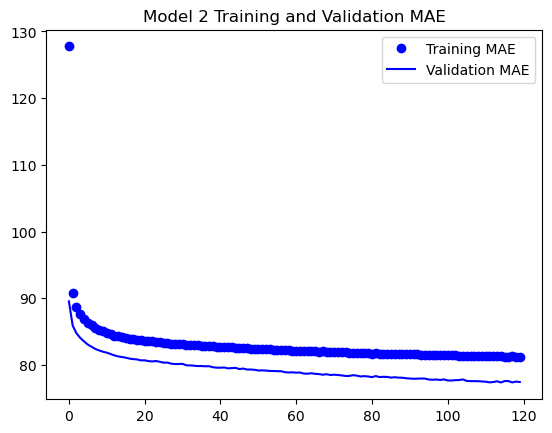

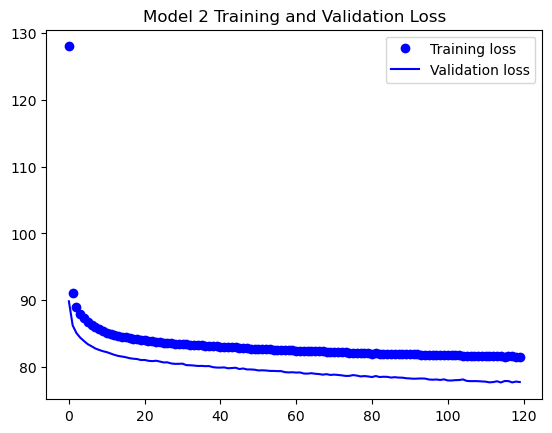

In [54]:
#Plot the model's train MAE, validation MAE, train loss, and validation loss by each epoch using the model's
    #histoire variable
model2_mae = model2_nn_histoire.history['mae']
model2_val_mae = model2_nn_histoire.history['val_mae']
model2_loss = model2_nn_histoire.history['loss']
model2_val_loss = model2_nn_histoire.history['val_loss']
model2_epochs = range(len(model2_mae))

plt.plot(model2_epochs, model2_mae, 'bo', label = 'Training MAE')
plt.plot(model2_epochs, model2_val_mae, 'b', label = 'Validation MAE')
plt.title('Model 2 Training and Validation MAE')
plt.legend()
plt.figure()
plt.plot(model2_epochs, model2_loss, 'bo', label = 'Training loss')
plt.plot(model2_epochs, model2_val_loss, 'b', label = 'Validation loss')
plt.title('Model 2 Training and Validation Loss')
plt.legend()
plt.show();

In [55]:
model2_nn_train_preds = model2_nn.predict(model2_X_train_scaled)
model2_nn_test_preds = model2_nn.predict(model2_X_test_scaled)

2023-01-05 11:37:00.106129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [56]:
print(f'Model 2 train MAE w/ preds {mean_absolute_error(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 test MAE w/ preds {mean_absolute_error(model2_y_test.values, model2_nn_test_preds)}')
print(f'Model 2 explained variance train score {explained_variance_score(model2_y_train.values, model2_nn_train_preds)}')
print(f'Model 2 explained variance test score {explained_variance_score(model2_y_test.values, model2_nn_test_preds)}')

Model 2 train MAE w/ preds 77.66574497350585
Model 2 test MAE w/ preds 77.56945379697093
Model 2 explained variance train score 0.5556025985924817
Model 2 explained variance test score 0.5566181015923273


## Model 3 - Random Forest

In [ ]:
%%time

#Create a model 3 X and y variable
model3_X = austin_modeling_data.drop(['daily_price', 'listing_id', 'coords'], axis = 1)
model3_y = austin_modeling_data['daily_price']

#Train, test, split the X and y variables
model3_X_train, model3_X_test, model3_y_train, model3_y_test = train_test_split(model3_X, 
                                                                                model3_y, 
                                                                                test_size = 0.2)

#Create a list of numeric columns
model3_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_falls_park', 'distance_to_downtown', 'distance_to_capitol']

#Create a list of nominal columns
model3_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

#Scale the numeric columns
model3_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

#One hot encode the nominal columns
model3_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

#Column tranform the two pipelines
ct = ColumnTransformer([('nominalpipe', model3_nominal_pipeline, model3_nominal_cols ),
                        ('numpipe', model3_numeric_pipeline, model3_numeric_cols)])

#Column tranform the two pipelines
model3_final_pipe = Pipeline([('preprocess', ct),
                              ('model', RandomForestRegressor())])

model3_results = model3_final_pipe.fit(model3_X_train, model3_y_train)

Model 3 train accuracy 0.9961603146445854
Model 3 train MSE 11.698094363118388
Model 3 train MAE 2.5512817119307227


Model 3 test accuracy 0.9789111569182158
Model 3 test MSE 27.447738510261974
Model 3 test MAE 6.324182763515395


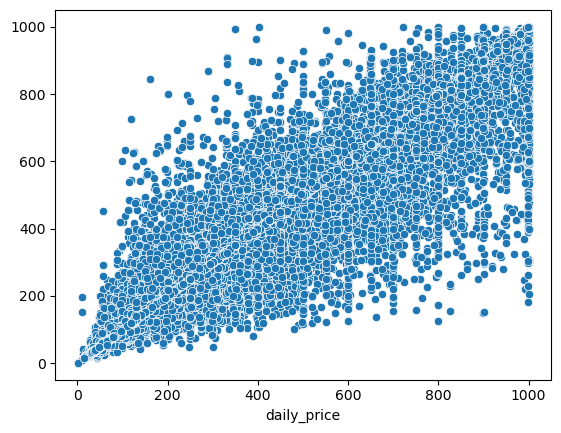

In [58]:
model3_train_preds = model3_final_pipe.predict(model3_X_train)
model3_test_preds = model3_final_pipe.predict(model3_X_test)

print(f'Model 3 train accuracy {model3_final_pipe.score(model3_X_train, model3_y_train)}')
print(f'Model 3 train MSE {mean_squared_error(model3_y_train, model3_train_preds, squared = False)}')
print(f'Model 3 train MAE {mean_absolute_error(model3_y_train, model3_train_preds)}')
print(f'\n')
print(f'Model 3 test accuracy {model3_final_pipe.score(model3_X_test, model3_y_test)}')
print(f'Model 3 test MSE {mean_squared_error(model3_y_test, model3_test_preds, squared = False)}')
print(f'Model 3 test MAE {mean_absolute_error(model3_y_test, model3_test_preds)}')

sns.scatterplot(y = model3_test_preds, x = model3_y_test);

## Model 4 - Random Forest

In [59]:
model4_X = austin_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model4_y = austin_modeling_data['daily_price']

model4_X_train, model4_X_test, model4_y_train, model4_y_test = train_test_split(model4_X, 
                                                                                model4_y, 
                                                                                test_size = 0.2)

model4_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_falls_park', 'distance_to_downtown', 'distance_to_capitol']

model4_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model4_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model4_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model4_nominal_pipeline, model4_nominal_cols ),
                        ('numpipe', model4_numeric_pipeline, model4_numeric_cols)])

model4_final_pipe = Pipeline([('preprocess', ct),
                              ('rf', RandomForestRegressor(min_samples_leaf = 23,
                                                          max_depth = 23,
                                                           min_samples_split = 23))])

model4_final_pipe.fit(model4_X_train, model4_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['neighborhood', 'room_type',
                                                   'day_of_week', 'month',
                                                   'week']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['host_is_superhost',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'bathrooms',
                                                   'Air conditioning', 'Wifi',
                                                   'TV', 'Kitchen', 'Washer',
                                                   'Dryer', 'Heating',
                                                   'distance_to_falls_park',
                                                   'distance_to_downtown',
                                                   'distance_to_capitol'])])),
                ('rf',
                 RandomForestRegressor(max_depth=23, min_samples_leaf=23,
                                       min_samples_split=23))])

Model 4 train accuracy 0.9526488442563565
Model 4 train MSE 41.094212249995856
Model 4 train MAE 16.31956478726924


Model 4 test accuracy 0.9490862945157156
Model 4 test MSE 42.5898485419539
Model 4 test MAE 16.800340703862148


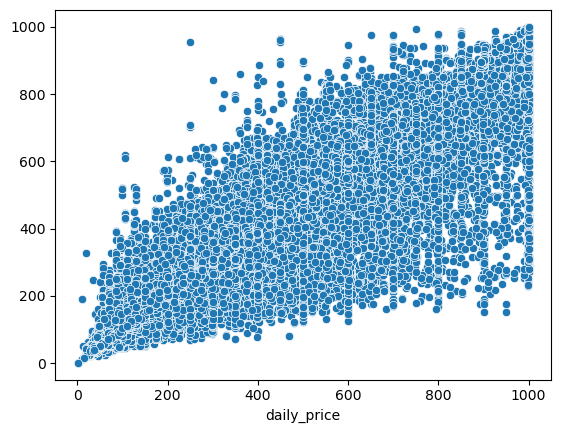

In [60]:
model4_train_preds = model4_final_pipe.predict(model4_X_train)
model4_test_preds = model4_final_pipe.predict(model4_X_test)

print(f'Model 4 train accuracy {model4_final_pipe.score(model4_X_train, model4_y_train)}')
print(f'Model 4 train MSE {mean_squared_error(model4_y_train, model4_train_preds, squared = False)}')
print(f'Model 4 train MAE {mean_absolute_error(model4_y_train, model4_train_preds)}')
print(f'\n')
print(f'Model 4 test accuracy {model4_final_pipe.score(model4_X_test, model4_y_test)}')
print(f'Model 4 test MSE {mean_squared_error(model4_y_test, model4_test_preds, squared = False)}')
print(f'Model 4 test MAE {mean_absolute_error(model4_y_test, model4_test_preds)}')

sns.scatterplot(y = model4_test_preds, x = model4_y_test);

## Model 5 - XGBoost

In [61]:
model5_X = austin_modeling_data.drop(['daily_price', 'listing_id'], axis = 1)
model5_y = austin_modeling_data['daily_price']

model5_X_train, model5_X_test, model5_y_train, model5_y_test = train_test_split(model5_X, 
                                                                                model5_y, 
                                                                                test_size = 0.2)

model5_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating',
                       'distance_to_falls_park', 'distance_to_downtown', 'distance_to_capitol']

model5_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month', 'week']

model5_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

model5_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', model5_nominal_pipeline, model5_nominal_cols ),
                        ('numpipe', model5_numeric_pipeline, model5_numeric_cols)])

model5_final_pipe = Pipeline([('preprocess', ct),
                              ('xg', xgb.XGBRegressor(n_estimators = 1000, 
                                                  max_depth = 7, 
                                                  eta = 0.1, 
                                                  subsample = 0.7, 
                                                  colsample_bytree = 0.8))])

model5_final_pipe.fit(model5_X_train, model5_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['neighborhood', 'room_type',
                                                   'day_of_week', 'month',
                                                   'week']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['host_is_superhost',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'bathrooms',
                                                   'Air conditioning', 'Wifi',
                                                   'TV', 'Kitche...
                              eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.100000001, max_delta_step=0,
                              max_depth=7, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=1000,
                              n_jobs=10, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.7,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

Model 5 train accuracy 0.9321112838560317
Model 5 train MSE 49.20789361563626
Model 5 train MAE 30.62205593182462


Model 5 test accuracy 0.9296169444120906
Model 5 test MSE 50.06566226430455
Model 5 test MAE 30.945933269815214


Text(0.5, 1.0, 'Model 5 Preds')

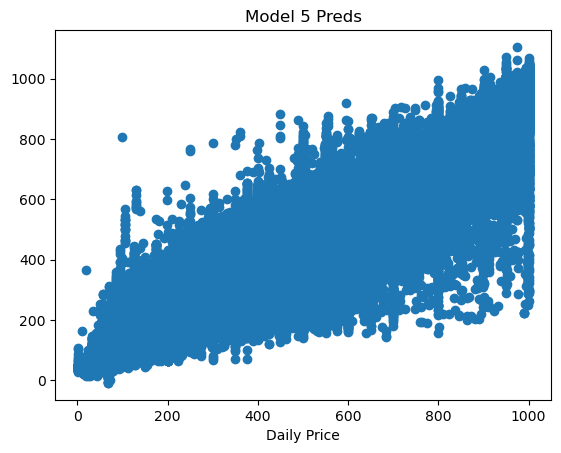

In [62]:
model5_train_preds = model5_final_pipe.predict(model5_X_train)
model5_test_preds = model5_final_pipe.predict(model5_X_test)

model5_train_accuracy = model5_final_pipe.score(model5_X_train, model5_y_train)
model5_train_MSE = mean_squared_error(model5_y_train, model5_train_preds, squared = False)
model5_train_MAE = mean_absolute_error(model5_y_train, model5_train_preds)
model5_test_accuracy = model5_final_pipe.score(model5_X_test, model5_y_test)
model5_test_MSE = mean_squared_error(model5_y_test, model5_test_preds, squared = False)
model5_test_MAE = mean_absolute_error(model5_y_test, model5_test_preds)

print(f'Model 5 train accuracy {model5_train_accuracy}')
print(f'Model 5 train MSE {model5_train_MSE}')
print(f'Model 5 train MAE {model5_train_MAE}')
print(f'\n')
print(f'Model 5 test accuracy {model5_test_accuracy}')
print(f'Model 5 test MSE {model5_test_MSE}')
print(f'Model 5 test MAE {model5_test_MAE}')

plt.scatter(model5_y_test, model5_test_preds)
plt.xlabel('Daily Price')
plt.title('Model 5 Preds')

## Testing Predictions

In [63]:
host_superhost = input('Host is Superhost (Y/N): ')
room_type = input('Room Type (Entire home/apt or Private room)')
accommodates = input('Accomodates (1-16) Guests: ')
num_of_bedrooms = input('Number of Bedrooms: ')
num_of_beds = input('Number of Beds: ')
select_neighborhood = input('Neighborhood (Nashville): ')
num_of_bathrooms = input('Number of Bathrooms: ')
check_AC = input('AC (Y/N): ')
check_wifi = input('Wifi (Y/N): ')
check_TV = input('TV (Y/N): ')
check_kitchen = input('Kitchen (Y/N): ')
check_washer = input('Washer (Y/N): ')
check_dryer = input('Dryer (Y/N): ')
check_heating = input('Heating (Y/N): ')
select_latitude = input('Latitude: ')
select_longitude = input('Longitude: ')
checkin_date = input('Check-in Date: ')
checkout_date = input('Check-out Date: ')


Host is Superhost (Y/N): Y
Room Type (Entire home/apt or Private room)Entire home/apt
Accomodates (1-16) Guests: 4
Number of Bedrooms: 2
Number of Beds: 4
Neighborhood (Asheville/Candler/Fletcher/Woodfin): Nashville
Number of Bathrooms: 2
AC (Y/N): Y
Wifi (Y/N): Y
TV (Y/N): Y
Kitchen (Y/N): Y
Washer (Y/N): Y
Dryer (Y/N): Y
Heating (Y/N): Y
Latitude: 50
Longitude: -50
Check-in Date: 1/9/2023
Check-out Date: 1/16/2023


In [66]:
def yes_no_conversion(input):
    if input == 'Y':
        return 1
    else:
        return 0

In [68]:
conv_long = float(select_longitude)
conv_lat = float(select_latitude)
test_coords = list((conv_lat, conv_long))
predicted_checkin_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
                          test_coords,
                          geodesic(test_coords, falls_park).miles,
                          geodesic(test_coords, downtown).miles,
                          geodesic(test_coords, capitol).miles,
                          pd.to_datetime(checkin_date).dayofweek,
                          pd.to_datetime(checkin_date).month,
                          pd.to_datetime(checkin_date).week]

In [70]:
checkin_prediction_df = pd.DataFrame(predicted_checkin_list).T
checkin_prediction_df = checkin_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
                                      14: 'coords',
                                      15: 'distance_to_falls_park',
                                      16: 'distance_to_downtown',
                                      17: 'distance_to_capitol',                                                      
                                      18: 'day_of_week',
                                      19: 'month',
                                      20: 'week'}, axis = 1)

checkin_prediction_df

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,...,Washer,Dryer,Heating,coords,distance_to_falls_park,distance_to_downtown,distance_to_capitol,day_of_week,month,week
0,1,Entire home/apt,4,2,4,Nashville,2,1,1,1,...,1,1,1,"[50.0, -50.0]",2811.63169,2808.380211,2808.112151,0,1,2


In [73]:
predicted_checkout_list = [yes_no_conversion(host_superhost),
                          room_type,
                          int(accommodates),
                          int(num_of_bedrooms),
                          int(num_of_beds),
                          select_neighborhood,
                          int(num_of_bathrooms),
                          yes_no_conversion(check_AC),
                          yes_no_conversion(check_wifi),
                          yes_no_conversion(check_TV),
                          yes_no_conversion(check_kitchen),
                          yes_no_conversion(check_washer),
                          yes_no_conversion(check_dryer),                        
                          yes_no_conversion(check_heating),                         
                          test_coords,
                          geodesic(test_coords, falls_park).miles,
                          geodesic(test_coords, downtown).miles,
                          geodesic(test_coords, capitol).miles,
                          pd.to_datetime(checkout_date).dayofweek,
                          pd.to_datetime(checkout_date).month,
                          pd.to_datetime(checkout_date).week]

In [74]:
checkout_prediction_df = pd.DataFrame(predicted_checkout_list).T
checkout_prediction_df = checkout_prediction_df.rename({0: 'host_is_superhost', 
                                      1: 'room_type',
                                      2: 'accommodates',
                                      3: 'bedrooms',
                                      4: 'beds',
                                      5: 'neighborhood',
                                      6: 'bathrooms',
                                      7: 'Air conditioning',
                                      8: 'Wifi',
                                      9: 'TV',
                                      10: 'Kitchen',
                                      11: 'Washer',
                                      12: 'Dryer',
                                      13: 'Heating',
                                      14: 'coords',
                                      15: 'distance_to_falls_park',
                                      16: 'distance_to_downtown',
                                      17: 'distance_to_capitol',                                                      
                                      18: 'day_of_week',
                                      19: 'month',
                                      20: 'week'}, axis = 1)

checkout_prediction_df

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,...,Washer,Dryer,Heating,coords,distance_to_falls_park,distance_to_downtown,distance_to_capitol,day_of_week,month,week
0,1,Entire home/apt,4,2,4,Nashville,2,1,1,1,...,1,1,1,"[50.0, -50.0]",2811.63169,2808.380211,2808.112151,0,1,3


In [76]:
# checkin_price = float(model3_final_pipe.predict(checkin_prediction_df))
# checkout_price = float(model3_final_pipe.predict(checkout_prediction_df))
# average_price = (checkin_price + checkout_price) / 2
# total_stay_days = (pd.to_datetime(checkout_date) - pd.to_datetime(checkin_date)).days

# print(f'Checkin price ${checkin_price} per night')
# print(f'Checkout price ${checkout_price} per night')
# print(f'Total price of stay ${int((average_price * total_stay_days))}')
# print(f'Average daily price ${average_price}')